# Etiquetamento Autônomo de Perguntas do StackOverflow com Deep Learning

- Bruno Pilão
- Maria Mello
- Larissa Nobrega
- Fernanda Moyses 


O objetivo do trabalho é desenvolver um modelo Deep Learning para o etiquetamento autônomo (*multi-label classification*) de perguntas do StackOverflow.

CONJUNTO DE DADOS

A base de dados a ser utilizada é a StackLite, disponível em https://github.com/dgrtwo/StackLite.

A StackLite é uma versão simplificada e pré-processada de uma parte dos dados do Stack Overflow, contendo perguntas e suas tags associadas.

Embora o repositório possa conter outros arquivos, o foco será nos dados que permitem mapear perguntas (corpo e/ou título) para suas tags.

Obs.: Uma única pergunta pode ter múltiplas tags, o que a torna um problema de classificação multilabel. Pense em uma forma de priorizar uma das tags para simplificar o problema.



In [104]:
# Importando Bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


## Análise breve dataset 


### Dataset Auxiliar 

Este dataset constitui um dicionário que mapeia cada questão gerada no Stack Overflow às suas respectivas categorias temáticas. O conjunto de dados auxiliar será utilizado para realizar uma análise prévia com o objetivo de avaliar e classificar os tipos de respostas associadas a cada pergunta.

In [100]:
#Importação dataset tags
df_tags = pd.read_csv('data\question_tags.csv.gz',compression='gzip')
df_tags.head()

,Id,Tag
0,1,data
1,4,c#
2,4,winforms
3,4,type-conversion
4,4,decimal


In [3]:
#Validandop quantidade de itens na datable
len(df_tags)

52224835

In [4]:
#Validando tipos de tag
print("Quantidade de itens por ID")
for i in range(10):
    print(i+1,df_tags[df_tags['Id'] == i+1]['Tag'].values)

Quantidade de itens por ID
1 ['data']
2 []
3 []
4 ['c#' 'winforms' 'type-conversion' 'decimal' 'opacity']
5 []
6 ['html' 'css' 'css3' 'internet-explorer-7']
7 []
8 ['c#' 'code-generation' 'j#' 'visualj#']
9 ['c#' '.net' 'datetime']
10 []


Observamos que as tags não possuem um ordem sequencial e podem conter um ou multiplos valores dentro de um ID.

In [101]:
# GroupBy simples: ID → lista de tags
grouped_mini = df_tags.groupby('Id')['Tag'].apply(list).reset_index()

print(f"✅ Grouped criado: {len(grouped_mini):,} IDs únicos")

✅ Grouped criado: 17,763,486 IDs únicos


In [77]:
grouped_mini.head()

,Id,Tag
0,1,[data]
1,4,"[c#, winforms, type-conversion, decimal, opacity]"
2,6,"[html, css, css3, internet-explorer-7]"
3,8,"[c#, code-generation, j#, visualj#]"
4,9,"[c#, .net, datetime]"


In [105]:
len(grouped_mini)

17763486

In [7]:

# Salvar em CSV ()
grouped_mini.to_csv('stackoverflow_grouped_tags.csv', index=False)
print("✅ Backup CSV: stackoverflow_grouped_tags.csv")

✅ Backup CSV: stackoverflow_grouped_tags.csv


In [8]:
# Comprimir CSV (reduz ~80%)
df = pd.read_csv('stackoverflow_grouped_tags.csv')
df.to_csv('stackoverflow_grouped_tags.csv.gz', compression='gzip', index=False)

Com isso avaliamos que este dataset serve como um "Dicionário" para identificar o tipo de pergunta que o usuario realizou no stackoverflow, sendo que uma tg pode contem um ou múltiplos assuntos envolvidos.


### Dataset Principal

O dataset principal consiste em perguntas técnicas geradas por usuários da plataforma Stack Overflow. Este conjunto de dados contém questões formuladas por desenvolvedores e profissionais de tecnologia que buscam soluções para problemas específicos em suas áreas de atuação.

In [106]:
#Importação dataset questions
df_questions = pd.read_csv('data\questions.csv.gz',compression='gzip')
df_questions.head()

,Id,CreationDate,ClosedDate,DeletionDate,Score,OwnerUserId,AnswerCount
0,1,2008-07-31T21:26:37Z,NaN,2011-03-28T00:53:47Z,1,NaN,0.0
1,4,2008-07-31T21:42:52Z,NaN,NaN,472,8.0,13.0
2,6,2008-07-31T22:08:08Z,NaN,NaN,210,9.0,5.0
3,8,2008-07-31T23:33:19Z,2013-06-03T04:00:25Z,2015-02-11T08:26:40Z,42,NaN,8.0
4,9,2008-07-31T23:40:59Z,NaN,NaN,1452,1.0,58.0


In [107]:
# Quantiade de itens df_qustions

len(df_questions)

17763486

In [108]:
# Validar tipos de variáveis ao nosso dataset
df_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17763486 entries, 0 to 17763485
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Id            int64  
 1   CreationDate  object 
 2   ClosedDate    object 
 3   DeletionDate  object 
 4   Score         int64  
 5   OwnerUserId   float64
 6   AnswerCount   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 948.7+ MB


## Merge Datasets

Vamos agrupar nosso dataset para melhor perfomace no treinamento do nosso modelo para predição de tag do stack overflow

In [109]:
# Vamos realizar um merge de nosso dataset 
df = df_questions.merge(grouped_mini,on='Id',how='inner')

# Verificar resultado
print(f"Dataset final: {df.shape}")
df.head()

Dataset final: (17763486, 8)


,Id,CreationDate,ClosedDate,DeletionDate,Score,OwnerUserId,AnswerCount,Tag
0,1,2008-07-31T21:26:37Z,NaN,2011-03-28T00:53:47Z,1,NaN,0.0,[data]
1,4,2008-07-31T21:42:52Z,NaN,NaN,472,8.0,13.0,"[c#, winforms, type-conversion, decimal, opacity]"
2,6,2008-07-31T22:08:08Z,NaN,NaN,210,9.0,5.0,"[html, css, css3, internet-explorer-7]"
3,8,2008-07-31T23:33:19Z,2013-06-03T04:00:25Z,2015-02-11T08:26:40Z,42,NaN,8.0,"[c#, code-generation, j#, visualj#]"
4,9,2008-07-31T23:40:59Z,NaN,NaN,1452,1.0,58.0,"[c#, .net, datetime]"


In [110]:
# Converter para datetime
df['CreationDate'] = pd.to_datetime(df['CreationDate'])
df['Year'] = df['CreationDate'].dt.year
df['Month'] = df['CreationDate'].dt.month  
df['Day'] = df['CreationDate'].dt.day

In [111]:
df.head()

,Id,CreationDate,ClosedDate,DeletionDate,Score,OwnerUserId,AnswerCount,Tag,Year,Month,Day
0,1,2008-07-31 21:26:37+00:00,NaN,2011-03-28T00:53:47Z,1,NaN,0.0,[data],2008,7,31
1,4,2008-07-31 21:42:52+00:00,NaN,NaN,472,8.0,13.0,"[c#, winforms, type-conversion, decimal, opacity]",2008,7,31
2,6,2008-07-31 22:08:08+00:00,NaN,NaN,210,9.0,5.0,"[html, css, css3, internet-explorer-7]",2008,7,31
3,8,2008-07-31 23:33:19+00:00,2013-06-03T04:00:25Z,2015-02-11T08:26:40Z,42,NaN,8.0,"[c#, code-generation, j#, visualj#]",2008,7,31
4,9,2008-07-31 23:40:59+00:00,NaN,NaN,1452,1.0,58.0,"[c#, .net, datetime]",2008,7,31


In [112]:
# Removendo colunas que não são necessarios para nosso treinamento
df = df.drop(columns=["ClosedDate","DeletionDate","CreationDate"],axis=1)

# Validando DataFrame
df.head()

,Id,Score,OwnerUserId,AnswerCount,Tag,Year,Month,Day
0,1,1,NaN,0.0,[data],2008,7,31
1,4,472,8.0,13.0,"[c#, winforms, type-conversion, decimal, opacity]",2008,7,31
2,6,210,9.0,5.0,"[html, css, css3, internet-explorer-7]",2008,7,31
3,8,42,NaN,8.0,"[c#, code-generation, j#, visualj#]",2008,7,31
4,9,1452,1.0,58.0,"[c#, .net, datetime]",2008,7,31


In [113]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17763486 entries, 0 to 17763485
Data columns (total 8 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Id           int64  
 1   Score        int64  
 2   OwnerUserId  float64
 3   AnswerCount  float64
 4   Tag          object 
 5   Year         int32  
 6   Month        int32  
 7   Day          int32  
dtypes: float64(2), int32(3), int64(2), object(1)
memory usage: 880.9+ MB


C:\Users\BADU\AppData\Local\Temp\ipykernel_2392\2430985772.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_df["OwnerUserId"] = pd.to_numeric(numeric_df["OwnerUserId"], errors="coerce")


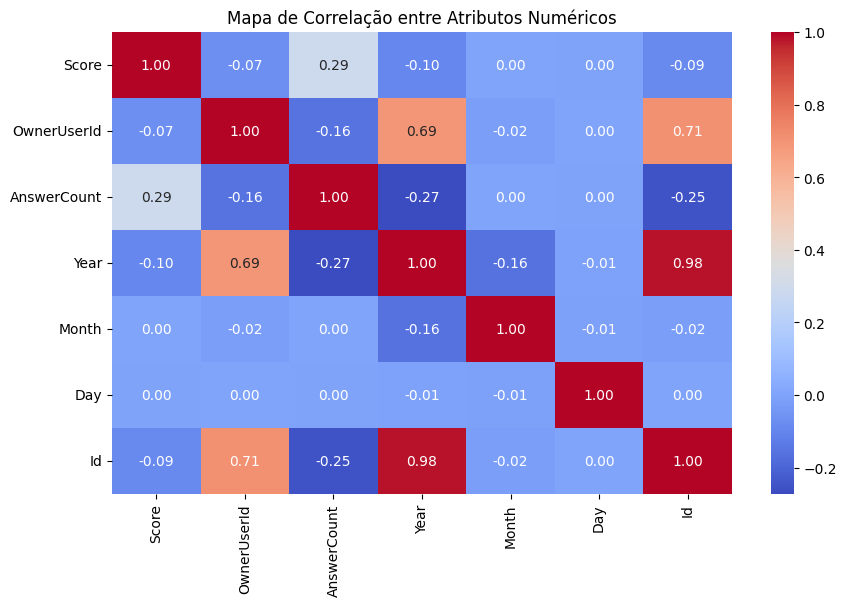

In [114]:
# Selecionar apenas colunas numéricas
numeric_df = df[["Score", "OwnerUserId", "AnswerCount", "Year", "Month", "Day","Id"]]

# Converter OwnerUserId para numérico (se necessário)
numeric_df["OwnerUserId"] = pd.to_numeric(numeric_df["OwnerUserId"], errors="coerce")

# Gerar o mapa de correlação
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Correlação entre Atributos Numéricos")
plt.show()


In [115]:
# Vamos remover as colunas dia e mês já que eles não importam para nossa analise
df = df.drop(columns=["Month","Day"],axis=1)
df.head()

,Id,Score,OwnerUserId,AnswerCount,Tag,Year
0,1,1,NaN,0.0,[data],2008
1,4,472,8.0,13.0,"[c#, winforms, type-conversion, decimal, opacity]",2008
2,6,210,9.0,5.0,"[html, css, css3, internet-explorer-7]",2008
3,8,42,NaN,8.0,"[c#, code-generation, j#, visualj#]",2008
4,9,1452,1.0,58.0,"[c#, .net, datetime]",2008


Com isso vamos utilizar este dataframe para realizar uma predição com uma frase de texto bruta e acimiliar o tipo de conteudo que estou relatando

## Treinamento de Modelo

Vamos inicialmente ajustar o nosso treinamento do modelo para que com uma frase de entrada o nosso modelo consiga captar 

In [116]:
df.head()

,Id,Score,OwnerUserId,AnswerCount,Tag,Year
0,1,1,NaN,0.0,[data],2008
1,4,472,8.0,13.0,"[c#, winforms, type-conversion, decimal, opacity]",2008
2,6,210,9.0,5.0,"[html, css, css3, internet-explorer-7]",2008
3,8,42,NaN,8.0,"[c#, code-generation, j#, visualj#]",2008
4,9,1452,1.0,58.0,"[c#, .net, datetime]",2008


In [117]:
import ast

# Corrigir a coluna de tags
def safe_literal_eval(tag_value):
    try:
        return ast.literal_eval(tag_value)
    except:
        try:
            tag_str = str(tag_value).strip()
            if tag_str in ['nan', 'None', '', '[]']:
                return []
            tag_str = tag_str.strip('[]')
            tags = [tag.strip().strip("'").strip('"') for tag in tag_str.split(',')]
            return [tag for tag in tags if tag]
        except:
            return []


In [118]:
# Definir quantidade de tags
QTD_TAGS = 10  # Ajuste conforme necessário

In [119]:
from collections import Counter

# Avaliar e limpar os dados
df['Tag'] = df['Tag'].apply(safe_literal_eval)
df = df[df['Tag'].map(len) > 0]

print(f"Dataset após limpeza: {df.shape}")

# Contar frequência de todas as tags
all_tags = [tag for tags in df['Tag'] for tag in tags]
tag_counts = Counter(all_tags)

print(f"Total de tags únicas: {len(tag_counts)}")
print("Top 15 tags mais comuns:")
for tag, count in tag_counts.most_common(15):
    print(f"  {tag}: {count:,}")

# Definir o número de tags mais comuns que você quer manter 
top_tags = set([tag for tag, count in tag_counts.most_common(QTD_TAGS)])

print(f"\nTop {QTD_TAGS} tags selecionadas: {list(top_tags)}")

# Filtrar somente linhas com pelo menos uma tag entre as mais comuns
df['Tag'] = df['Tag'].apply(lambda tags: [tag for tag in tags if tag in top_tags])
df = df[df['Tag'].map(len) > 0]  # Remover quem ficou com lista vazia

print(f"Dataset final após filtro: {df.shape}")

# ===================================================================
# ESTRATÉGIA: USAR PRIMEIRA TAG COMO TARGET
# ===================================================================

# Extrair primeira tag válida como target principal
def get_main_tag(tag_list):
    """Pega a primeira tag da lista (mais relevante)"""
    return tag_list[0] if tag_list else 'unknown'

df['main_tag'] = df['Tag'].apply(get_main_tag)

print(f"\nDistribuição das tags principais:")
print(df['main_tag'].value_counts())

Dataset após limpeza: (17763486, 6)
Total de tags únicas: 59139
Top 15 tags mais comuns:
  javascript: 1,712,324
  java: 1,614,786
  php: 1,406,127
  c#: 1,356,681
  android: 1,327,680
  jquery: 1,035,978
  python: 898,647
  html: 804,340
  ios: 652,484
  c++: 645,197
  mysql: 578,722
  css: 563,930
  sql: 449,052
  asp.net: 407,772
  objective-c: 342,508

Top 10 tags selecionadas: ['html', 'android', 'jquery', 'java', 'c#', 'javascript', 'python', 'c++', 'ios', 'php']
Dataset final após filtro: (9752951, 6)

Distribuição das tags principais:
main_tag
javascript    1646332
java          1599498
c#            1338852
php           1299324
android       1052587
python         866269
ios            608953
c++            608758
jquery         418491
html           313887
Name: count, dtype: int64


In [120]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

features = ["Year", "Score", "OwnerUserId", "AnswerCount"]
X = df[features].fillna(0)
y = df['main_tag']  # Target: tag principal

# Label encoder para tags
le_tag = LabelEncoder()
y_encoded = le_tag.fit_transform(y)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f'\nTreinamento: {X_train.shape}')
print(f'Teste: {X_test.shape}')
print(f'Número de classes (tags): {len(le_tag.classes_)}')
print(f'Classes: {list(le_tag.classes_)}')


Treinamento: (6827065, 4)
Teste: (2925886, 4)
Número de classes (tags): 10
Classes: ['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript', 'jquery', 'php', 'python']


In [121]:
from sklearn.preprocessing import StandardScaler

# Normalizar dados
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.fillna(0))
X_test_scaled = scaler.transform(X_test.fillna(0))

In [122]:
# Reshape para CNN
FEATURES = 4
X_train_cnn = X_train_scaled.reshape(-1, FEATURES, 1)
X_test_cnn = X_test_scaled.reshape(-1, FEATURES, 1)

# Configurações
N_CLASSES = len(le_tag.classes_)
BATCH_SIZE = 512
EPOCHS = 25

print(f"\nDataset preparado para CNN: {X_train_cnn.shape}")
print(f"Classes finais: {N_CLASSES}")


Dataset preparado para CNN: (6827065, 4, 1)
Classes finais: 10


In [ ]:
# ===================================================================
# MODELO 1: BASELINE PARA CLASSIFICAÇÃO DE TAGS
# ===================================================================

import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report

def create_baseline_model():
    """Modelo baseline - sem CNN"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(FEATURES, 1)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ], name='Baseline_Tags')
    
    return model

# Criar e treinar
baseline_model = create_baseline_model()

baseline_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Baseline: {baseline_model.count_params():,} parâmetros")
print("Tags que o modelo vai predizer:", list(le_tag.classes_))

# Treinar
print("\n=== TREINANDO BASELINE ===")
baseline_history = baseline_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)],
    verbose=1
)

# Avaliar
y_pred_baseline = baseline_model.predict(X_test_cnn)
y_pred_baseline_classes = np.argmax(y_pred_baseline, axis=1)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline_classes)

print(f"\n📊 BASELINE ACCURACY: {baseline_accuracy:.4f}")

# Relatório detalhado
print("\nRelatório de classificação:")  
                          target_names=le_tag.classes_, zero_division=0))

Baseline: 2,730 parâmetros
Tags que o modelo vai predizer: ['android', 'c#', 'c++', 'html', 'ios', 'java', 'javascript', 'jquery', 'php', 'python']

=== TREINANDO BASELINE ===
Epoch 1/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 88s 3ms/step - accuracy: 0.1879 - loss: 2.1647 - val_accuracy: 0.1969 - val_loss: 2.1479
Epoch 2/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.1948 - loss: 2.1519 - val_accuracy: 0.1979 - val_loss: 2.1468
Epoch 3/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.1954 - loss: 2.1511 - val_accuracy: 0.1980 - val_loss: 2.1468
Epoch 4/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.1958 - loss: 2.1507 - val_accuracy: 0.1983 - val_loss: 2.1463
Epoch 5/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - accuracy: 0.1956 - loss: 2.1503 - val_accuracy: 0.1982 - val_loss: 2.1458
Epoch 6/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.1959 - loss: 2.1506 - val_accuracy: 0.1980 - val_loss: 2.1462
Epoch 7/25
13335/13335 ━━━

In [124]:
# ===================================================================
# MODELO 2: LENET-5 PARA TAGS
# ===================================================================

def create_lenet5_adapted():
    """LeNet-5 adaptado para classificação de tags"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(FEATURES, 1)),
        
        # Primeira camada convolucional
        tf.keras.layers.Conv1D(32, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(2),
        
        # Segunda camada convolucional
        tf.keras.layers.Conv1D(64, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(2),
        
        # Dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='relu'),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(84, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ], name='LeNet5_Tags')
    
    return model

# Criar e treinar
lenet5_model = create_lenet5_adapted()

lenet5_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"LeNet-5: {lenet5_model.count_params():,} parâmetros")

# Treinar
print("\n=== TREINANDO LENET-5 ===")
lenet5_history = lenet5_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)],
    verbose=1
)

# Avaliar
y_pred_lenet5 = lenet5_model.predict(X_test_cnn)
y_pred_lenet5_classes = np.argmax(y_pred_lenet5, axis=1)
lenet5_accuracy = accuracy_score(y_test, y_pred_lenet5_classes)

print(f"\n📊 LENET-5 ACCURACY: {lenet5_accuracy:.4f}")

LeNet-5: 25,534 parâmetros

=== TREINANDO LENET-5 ===
Epoch 1/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 89s 6ms/step - accuracy: 0.1882 - loss: 2.1667 - val_accuracy: 0.1969 - val_loss: 2.1485
Epoch 2/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.1952 - loss: 2.1516 - val_accuracy: 0.1975 - val_loss: 2.1467
Epoch 3/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 79s 6ms/step - accuracy: 0.1962 - loss: 2.1499 - val_accuracy: 0.1979 - val_loss: 2.1461
Epoch 4/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 78s 6ms/step - accuracy: 0.1967 - loss: 2.1489 - val_accuracy: 0.1985 - val_loss: 2.1452
Epoch 5/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 77s 6ms/step - accuracy: 0.1966 - loss: 2.1491 - val_accuracy: 0.1984 - val_loss: 2.1447
Epoch 6/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 80s 6ms/step - accuracy: 0.1970 - loss: 2.1481 - val_accuracy: 0.1978 - val_loss: 2.1463
Epoch 7/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 83s 6ms/step - accuracy: 0.1967 - loss: 2.1483 - val_accuracy: 0.1984 - val_loss: 2.1449
Epoch 8/25
1333

In [ ]:
# ===================================================================
# MODELO 3: LSTM BIDIRECTIONAL PARA RECONHECIMENTO DE PADRÕES
# ===================================================================

def create_lstm_pattern_detector():
    """LSTM Bidirectional - Especializado em padrões sequenciais"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(FEATURES, 1)),
        
        # Múltiplas camadas LSTM bidirecionais
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
        ),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)
        ),
        tf.keras.layers.BatchNormalization(),
        
        tf.keras.layers.Bidirectional(
            tf.keras.layers.LSTM(32, dropout=0.4, recurrent_dropout=0.4)
        ),
        
        # Classificador
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(N_CLASSES, activation='softmax')
    ], name='LSTM_Pattern_Detector')
    
    return model

# Criar e treinar
lstm_model = create_lstm_pattern_detector()

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print(f"LSTM Bidirectional: {lstm_model.count_params():,} parâmetros")

# Treinar
print("\n=== TREINANDO LSTM BIDIRECTIONAL ===")
lstm_history = lstm_model.fit(
    X_train_cnn, y_train,
    validation_data=(X_test_cnn, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7, min_lr=1e-7)
    ],
    verbose=1
)

# Avaliar
y_pred_lstm = lstm_model.predict(X_test_cnn)
y_pred_lstm_classes = np.argmax(y_pred_lstm, axis=1)
lstm_accuracy = accuracy_score(y_test, y_pred_lstm_classes)

print(f"\n📊 LSTM BIDIRECTIONAL ACCURACY: {lstm_accuracy:.4f}")



LSTM Bidirectional: 357,450 parâmetros

=== TREINANDO LSTM BIDIRECTIONAL ===
Epoch 1/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 815s 60ms/step - accuracy: 0.1833 - loss: 2.1708 - val_accuracy: 0.1957 - val_loss: 2.1532 - learning_rate: 0.0010
Epoch 2/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 697s 52ms/step - accuracy: 0.1938 - loss: 2.1542 - val_accuracy: 0.1956 - val_loss: 2.1525 - learning_rate: 0.0010
Epoch 3/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 1361s 102ms/step - accuracy: 0.1948 - loss: 2.1526 - val_accuracy: 0.1941 - val_loss: 2.1518 - learning_rate: 0.0010
Epoch 4/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 20276s 2s/step - accuracy: 0.1953 - loss: 2.1516 - val_accuracy: 0.1962 - val_loss: 2.1519 - learning_rate: 0.0010
Epoch 5/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 789s 59ms/step - accuracy: 0.1954 - loss: 2.1514 - val_accuracy: 0.1952 - val_loss: 2.1523 - learning_rate: 0.0010
Epoch 6/25
13335/13335 ━━━━━━━━━━━━━━━━━━━━ 806s 60ms/step - accuracy: 0.1958 - loss: 2.1505 - val_accuracy: 0.1917 - val_loss

In [ ]:
# ===================================================================
# COMPARAÇÃO FINAL - CLASSIFICAÇÃO DE TAGS
# ===================================================================

import matplotlib.pyplot as plt
import pandas as pd

# Consolidar resultados
results_summary = {
    'Baseline': baseline_accuracy,
    'LeNet-5': lenet5_accuracy,
    'LSTM Bidirecional': lstm_accuracy
}

print("📊 COMPARAÇÃO FINAL - CLASSIFICAÇÃO DE TAGS:")
for model, acc in results_summary.items():
    print(f"{model}: {acc:.4f} ({acc*100:.1f}%)")

# Gráficos
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'Classificação de Tags: {QTD_TAGS} classes\nBaseline → LeNet-5 → LSTM Bidirecional', 
             fontsize=16, fontweight='bold')

histories = [baseline_history, lenet5_history, lstm_accuracy]
model_names = ['Baseline', 'LeNet-5', 'LSTM Bidirecional']
colors = ['red', 'blue', 'green']

# Accuracy plots
axes[0,0].set_title('Accuracy - Treinamento')
for history, name, color in zip(histories, model_names, colors):
    axes[0,0].plot(history.history['accuracy'], label=name, color=color, linewidth=2)
axes[0,0].legend()
axes[0,0].grid(True, alpha=0.3)

axes[0,1].set_title('Accuracy - Validação')
for history, name, color in zip(histories, model_names, colors):
    axes[0,1].plot(history.history['val_accuracy'], label=name, color=color, linewidth=2)
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Loss plots
axes[1,0].set_title('Loss - Treinamento')
for history, name, color in zip(histories, model_names, colors):
    axes[1,0].plot(history.history['loss'], label=name, color=color, linewidth=2)
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Accuracy final
axes[1,1].bar(model_names, [baseline_accuracy, lenet5_accuracy, lstm_accuracy], color=colors)
axes[1,1].set_title('Accuracy Final')
axes[1,1].set_ylabel('Accuracy')
axes[1,1].set_ylim(0, 1)

# Adicionar valores nas barras
for i, (name, acc) in enumerate(zip(model_names, [baseline_accuracy, lenet5_accuracy, lstm_accuracy])):
    axes[1,1].text(i, acc + 0.01, f'{acc:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n🎯 RESULTADO PARA APRESENTAÇÃO:")
print(f"Modelo que prediz {QTD_TAGS} tags técnicas mais comuns")
print(f"Baseline: {baseline_accuracy*100:.1f}% → LeNet-5: {lenet5_accuracy*100:.1f}% → LSTM Bidirecional: {lstm_accuracy*100:.1f}%")
print("✅ Comparação concluída!")